In [1]:
from diffusion_gaussian_mixture_utils import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

In [2]:
weights = torch.tensor([0.3, 0.7])
data_means = torch.tensor([[-1.0, -1.0], [1.0, 1.0]])
data_covs = torch.tensor([[[1.0, 0.9], [0.9, 1.0]], [[1.0, -0.6], [-0.6, 1.0]]])

# Define the likelihood p(y|x₀)
cov_y = make_positive_semidefinite(torch.tensor([[0.5, 0.0], [0.0, 0.5]]))

y = torch.tensor([-0.7, 0.4])

In [6]:
min_sigma = 0.0
max_sigma = 10.0

schedule = lambda t: linear_sigma(t, min_sigma, max_sigma)
schedule_derivative = lambda t: linear_sigma_derivative(t, min_sigma, max_sigma)
score_function = lambda x, t: gaussian_mixture_log_gradient(x, weights, data_means, data_covs, schedule(t))

rho = 2.0
num_steps = 100
n_samples = 10000
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
prior_samples = torch.randn(n_samples, 2) * max_sigma
prior_samples[0,:] = torch.tensor([4., -4.])

samples, sample_trajectories, ts = sample_ode_with_predefined_prior_samples(prior_samples, schedule, schedule_derivative, score_function, num_steps, 'cpu', rho=rho,
                                                                 get_sample_paths=True)

In [8]:
min_sigma = 0.0
max_sigma = 20.0

schedule = lambda t: linear_sigma(t, min_sigma, max_sigma)
schedule_derivative = lambda t: linear_sigma_derivative(t, min_sigma, max_sigma)
score_function = lambda x, t: gaussian_mixture_log_gradient_conditional(x, y, weights, data_means, data_covs, schedule(t), cov_y)

rho = 2.0
num_steps = 100
n_samples = 10000
samples_conditional, sample_trajectories_conditional, ts_conditional = sample_ode_with_predefined_prior_samples(prior_samples, schedule, schedule_derivative, score_function, num_steps, 'cpu', rho=rho,
                                                                 get_sample_paths=True)

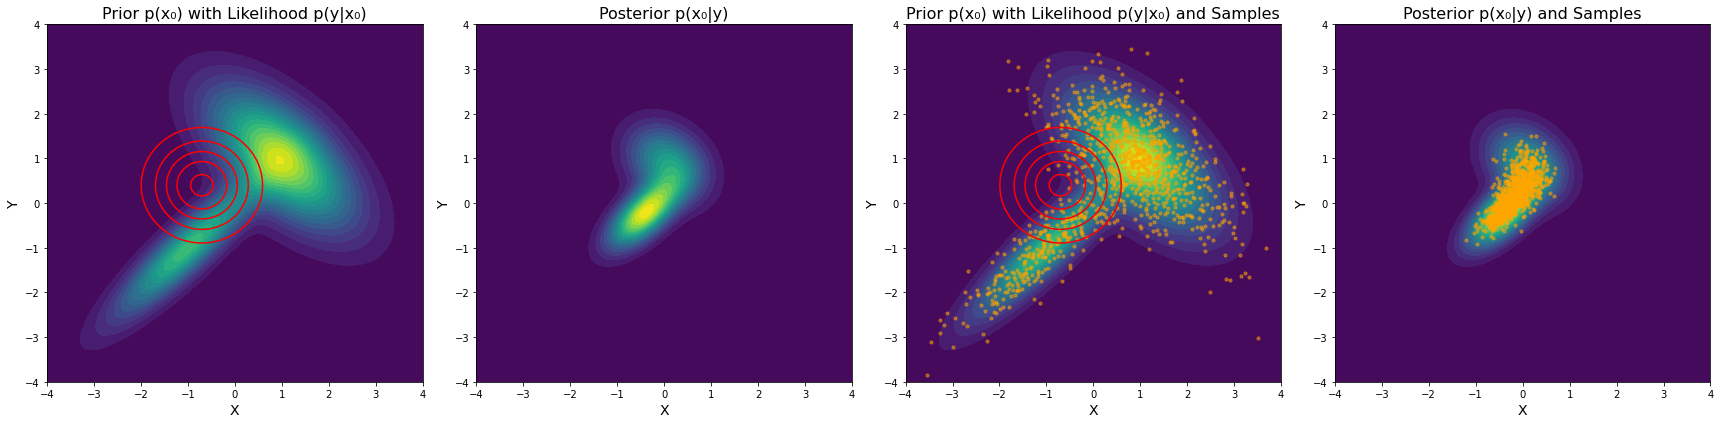

In [14]:
# Define p(x_t|x₀) for the plot
cov_xt = make_positive_semidefinite(torch.tensor([[1.0, 0.0], [0.0, 1.0]]))

# Create grid for plotting
X, Y, pos = create_grid((-4, 4), (-4, 4))

# Create a 1x4 subplot layout
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

Z_prior = gaussian_mixture(pos, weights, data_means, data_covs)
mvn_y = MultivariateNormal(y, cov_y)
Z_likelihood = torch.exp(mvn_y.log_prob(pos))

# Plot 1: Prior p(x₀) with Likelihood p(y|x₀)
contourf = axs[0].contourf(X, Y, Z_prior.reshape(X.shape), levels=20, cmap='viridis')
contour = axs[0].contour(X, Y, Z_likelihood.reshape(X.shape), levels=5, colors='red')
axs[0].set_title('Prior p(x₀) with Likelihood p(y|x₀)', fontsize=16)
axs[0].set_xlabel('X', fontsize=14)
axs[0].set_ylabel('Y', fontsize=14)

# Plot 2: Posterior p(x₀|y)
new_weights, new_means, new_covs = calculate_posterior(y, weights, data_means, data_covs, cov_y)
Z_posterior = gaussian_mixture(pos, new_weights, new_means, new_covs)
contourf = axs[1].contourf(X, Y, Z_posterior.reshape(X.shape), levels=20, cmap='viridis')
axs[1].set_title('Posterior p(x₀|y)', fontsize=16) 
axs[1].set_xlabel('X', fontsize=14)
axs[1].set_ylabel('Y', fontsize=14)

# Plot 3: Prior p(x₀) with Likelihood p(y|x₀) and samples
contourf = axs[2].contourf(X, Y, Z_prior.reshape(X.shape), levels=20, cmap='viridis')
contour = axs[2].contour(X, Y, Z_likelihood.reshape(X.shape), levels=5, colors='red')
axs[2].scatter(samples[::10, 0], samples[::10, 1], color='orange', alpha=0.5, s=10, label='Samples')
axs[2].set_title('Prior p(x₀) with Likelihood p(y|x₀) and Samples', fontsize=16)
axs[2].set_xlabel('X', fontsize=14)
axs[2].set_ylabel('Y', fontsize=14)
axs[2].set_xlim(-4, 4)
axs[2].set_ylim(-4, 4)

# Plot 4: Posterior p(x₀|y) and samples
contourf = axs[3].contourf(X, Y, Z_posterior.reshape(X.shape), levels=20, cmap='viridis')
axs[3].scatter(samples_conditional[::10, 0], samples_conditional[::10, 1], color='orange', alpha=0.5, s=10, label='Samples')
axs[3].set_title('Posterior p(x₀|y) and Samples', fontsize=16)
axs[3].set_xlabel('X', fontsize=14)
axs[3].set_ylabel('Y', fontsize=14)
axs[3].set_xlim(-4, 4)
axs[3].set_ylim(-4, 4)

plt.tight_layout()
plt.show()